In [17]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from numpy import cumsum
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import json
import pmdarima as pm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc
import pandas as pd

To earn $1000 in dividends from bgfv, rate 0.1416  you need to purchase 993.27 shares. current price*shares 7.11=7062.15

To earn $1000 in dividends from uwmc, rate 0.0825 you need to purchase 2494.08 shares. current price*shares 4.86=12121.21



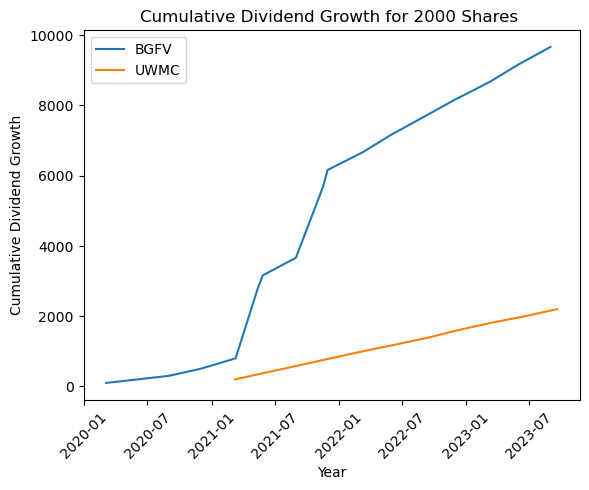

In [3]:
def plotARIMA(df,order,start,label):
    model=ARIMA(df, order=order)
    results=model.fit()
    forecast=results.get_prediction(start=start)
    mean_forecast=forecast.predicted_mean
    confidence_intervals=forecast.conf_int()
    lower_limit = confidence_intervals['lower '+label]
    upper_limit = confidence_intervals['upper '+label]
    plt.plot(df.index,df,color='green',label='NEE')
    plt.plot(mean_forecast.index, mean_forecast.values, color='red',label='forecast')
    plt.fill_between(lower_limit.index,lower_limit, upper_limit, color='pink')
    plt.xticks(rotation=45)
    plt.show()

def getDividend_Per_Share(symbol,earnings):
    # Get the stock data from Yahoo Finance
    stock_data = yf.Ticker(symbol)
    #print( stock_data.info)
    # Get the current stock price and dividend yield
    current_price = stock_data.info['regularMarketDayHigh']
    #dividend_yield = stock_data.info['dividendYield']
    dividend_yield = stock_data.info['dividendYield']
    # Calculate the dividend per share
    dividend_per_share = current_price * dividend_yield
    # Calculate the number of shares required to earn $1000 in dividends
    shares_required = earnings / dividend_per_share
    return stock_data,current_price,dividend_yield,dividend_per_share,shares_required

def getCumulative(stock_data):
    dividend_data = stock_data.dividends
    dividend_data = dividend_data.loc['2020':'2024']
    cumulative_dividend = (dividend_data * shares).cumsum()
    #print(cumulative_dividend)
    return cumulative_dividend

earnings=1000
bgfv_symbol="bgfv"
uwmc_symbol="uwmc"

bgfv_stock_data,bgfv_current_price,bgfv_dividend_yield,bgfv_dividend_per_share,bgfv_shares_required=getDividend_Per_Share(bgfv_symbol,earnings)
uwmc_stock_data,uwmc_current_price,uwmc_dividend_yield,uwmc_dividend_per_share,uwmc_shares_required=getDividend_Per_Share(uwmc_symbol,earnings)

print(f"To earn ${earnings} in dividends from {bgfv_symbol}, rate {bgfv_dividend_yield}  you need to purchase {bgfv_shares_required:.2f} shares. current price*shares {bgfv_current_price:.2f}={bgfv_current_price*bgfv_shares_required:.2f}\n")
print(f"To earn ${earnings} in dividends from {uwmc_symbol}, rate {uwmc_dividend_yield} you need to purchase {uwmc_shares_required:.2f} shares. current price*shares {uwmc_current_price:.2f}={uwmc_current_price*uwmc_shares_required:.2f}\n")

shares = 2000

bgfv_cumulative_dividend=getCumulative(bgfv_stock_data)
uwmc_cumulative_dividend=getCumulative(uwmc_stock_data)


plt.plot(bgfv_cumulative_dividend.index, bgfv_cumulative_dividend,label="BGFV")
plt.plot(uwmc_cumulative_dividend.index, uwmc_cumulative_dividend,label="UWMC")
plt.title(f'Cumulative Dividend Growth for {shares} Shares ')
plt.xlabel('Year')
plt.ylabel('Cumulative Dividend Growth')
plt.xticks(rotation=45)
plt.legend()
plt.show()


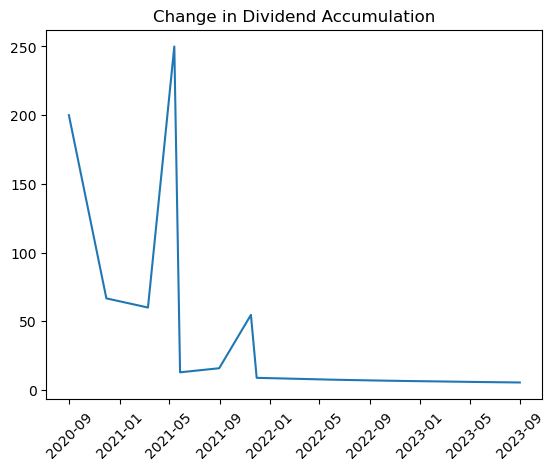

In [4]:
bgfv_change_yield_data=bgfv_cumulative_dividend.pct_change() * 100
plt.plot(bgfv_change_yield_data)
plt.title("Change in Dividend Accumulation")
plt.xticks(rotation=45)
plt.show()

C:\Users\dnishimoto\.conda\envs\Deeplearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnishimoto\.conda\envs\Deeplearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnishimoto\.conda\envs\Deeplearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


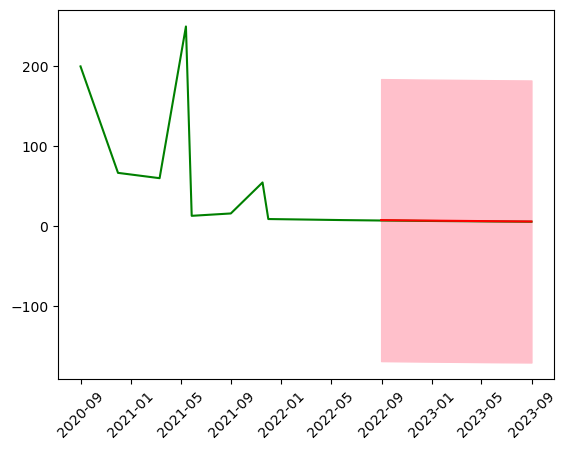

In [5]:
bgfv_df=bgfv_change_yield_data.to_frame(name="Dividend")

plotARIMA(bgfv_df, (0,1,0),-5,"Dividend")

In [6]:
results=pm.auto_arima(bgfv_df.dropna(),error_action='ignore')
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -82.886
Date:                Tue, 03 Oct 2023   AIC                            167.771
Time:                        14:30:38   BIC                            168.410
Sample:                             0   HQIC                           167.712
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8125.1111   2124.110      3.825      0.000    3961.933    1.23e+04
Ljung-Box (L1) (Q):                   3.33   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.07   Pr

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
[7.0393996 6.870382  6.870382  6.870382  7.042991  7.078732  7.043607 ]


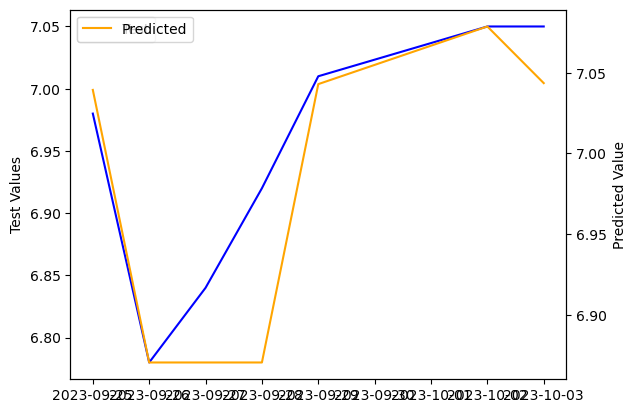

In [11]:
print(bgfv_stock_data.history().columns)
X=bgfv_stock_data.history()[["High","Low"]].sort_index()
y=bgfv_stock_data.history()["Close"].sort_index()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

params={
    'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5,
    'max_depth': 3,
    'objective': 'reg:squarederror'
}
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled,y_train)

dates=X_test.index
y_pred= model.predict(X_test_scaled)
print(y_pred)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dates,y_test, color="blue",label="Test")
ax2.plot(dates,y_pred, color="orange",label="Predicted")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Test Values")
ax2.set_ylabel("Predicted Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [31]:
#fig, ax = plt.subplots()
#df=bgfv_stock_data.history()["Close"].to_frame()
#candlestick_ohlc(ax, df, width=0.6, colorup='green', colordown='red', alpha=1.0)

